#Zadanie 2 (7 pkt)
Celem zadania jest rozwiązanie zadania optymalizacji przy pomocy algorytmu genetycznego. Należy znaleźć minimum zadanej funkcji:
\begin{equation}
f(x) = 1.5-\exp \left\{-x_1^2-x_2^2\right\}-0.5 \exp \left\{-\left(x_1-1\right)^2-\left(x_2+2\right)^2\right\}
\end{equation}
Należy wykorzystać mechanizmy krzyżowania punktowego, mutacji oraz selekcji turniejowej. Proszę wykorzystać przygotowany szkielet i zaimplementować niezbędne metody. Opracowane oprogramowanie powinno być uniwersalne - wymiar funkcji, której minimum szukamy może być dowolny (mechanizm *args). Punktacja wygląda następująco:

*   Stworzenie obiektu klasy *Chromosome* z polem *array*, które jest wektorem aktywnych i nieaktywnych genów - **0.5 pkt**
*   Implementacja metody *decode*, która dekoduje część chromosomu (określoną przez początek (*lower_bound*) i koniec (*upper_bound*)) do postaci liczby rzeczywistej. *aoi* to zakres wartości zdekodowanej liczby rzeczywistej. Przykład: liczba 135 w postaci binarnej zapisana przy użyciu 8 bitów to 1000 0111, jeśli nasze *aoi* to [0, 1], to 135 sprowadzone do tego zakresu to 0.529. Można skorzystać z funkcji pomocniczej *min_max_norm* - **1 pkt**
*   Implementacja metody *mutation*, która przyjmuje jako argument prawdopodobieństo mutacji i zmienia wartość jedego, losowego genu na przeciwną - **0.5 pkt**
*   Implementacja metody *crossover*, która wykonuje operację krzyżowania jednopunktowego - **1 pkt**
*   Implementacja metody *eval_objective_func*, która dekoduje cały chromosom (otrzymuje się argumenty funkcji) oraz zwraca wartość funkcji celu dla tych argumentów - **1 pkt**
*   Implementacja metody *tournament_selection*, która przeprowadza selekcję turniejową - **1 pkt**
*   Implementacja metody *reproduce*, która generuje nowe pokolenie - z pewnym prawdopodobieństwem przeprowadza krzyżowanie jednopunktowe lub "przerzuca" rodziców do nowego pokolenia - **0.5 pkt**
*   Implementacja metody *run*, która wykonuje cały alorytm genetyczny dla określonej liczby pokoleń. W każdym pokoleniu należy zapisać dane osobnika z najlepszym chromosomem zdekodowane wartości x i y oraz wartość funkcji strat dla tego osobnika - **0.5 pkt**
*   Proszę, podobnie jak miało to miejsce w przypadku metody gradientowej z poprzednich zajęć, wygenerować wykres przy użyciu funkcji *plot_func* (w przypadku innego typu argumentu *trace*, funkcję można zmodyfikować. Wykres powinien przedstawiać funkcję, której minimum poszukujemy oraz punkty odpowiadające najlepszym osobnikom w danych generacjach, których kolor jest coraz jaśniejszy wraz ze zbliżaniem się do minimum. Proszę zapisać swoje wnioski, w szczególności w odniesieniu do metody gradientowej. - **1 pkt**


In [1122]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [1123]:
debug = False
def min_max_norm(val, min_val, max_val, new_min, new_max):
  return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min
def decimal_value(array: np.array) -> int:
  value = 0
  for i,bit in enumerate(reversed(array)):
    value += 2**i * bit
  return value
def g_x(x1:float, x2:float) -> float:
  return 1.5-np.exp(-x1**(2)-x2**(2))-0.5*np.exp(-(x1-1)**(2)-(x2+2)**(2))

In [1124]:
#test decimal_value(np.array([1,1,1,0,0,1]))

In [1125]:

class Chromosome:
  def __init__(self, length, array=None): #if array is None it should be initialized with random binary vector
    if array is None:
      array = np.array([random.randint(0,1) for _ in range(length)])

    assert length == len(array), "Array length and length have to be the same"
    self.array = array
    self.length = length

  def decode(self, lower_bound, upper_bound, aoi) -> float:
    chromosome_to_decode = self.array[lower_bound:upper_bound]
    val = decimal_value(chromosome_to_decode)
    max_val = sum([2**index for index in range(len(chromosome_to_decode))])
    if debug:
      print(chromosome_to_decode, end="  |  ")
      print(val, end="  |  ")
      print(max_val, end="  |  ")
    return min_max_norm(val, 0, max_val, *aoi)

  def mutation(self, probability):
    if random.random() <= probability:
      bit_to_mutate = random.randint(0,self.length-1)
      self.array[bit_to_mutate] = 1 - self.array[bit_to_mutate]

  def crossover(self, other):
    cross_point = random.randint(0,self.length-1)
    child1 = Chromosome(self.length, np.concatenate((self.array[:cross_point], other.array[cross_point:])))
    child2 = Chromosome(self.length, np.concatenate((other.array[:cross_point], self.array[cross_point:])))
    if debug:
      print("Parents: ", self.array, "  |  ", other.array)
      print("Children:   ", child1.array, "  |  ", child2.array)
    return [child1, child2]
  def __str__(self):
    return f"Chromosome's array: {self.array}"

In [1126]:
def chromosome_test(length, array=None):
  c1 = Chromosome(length,array)
  array2 = array[::-1]
  c2 = Chromosome(length,array2)
  c3, c4 = c2.crossover(c1)
  c4.mutation(0.5)


In [1127]:
chromosome_test(10, np.array([0,0,0,0,0,1,1,1,1,1]))

In [1135]:
class GeneticAlgorithm:
  def __init__(self, chromosome_length, obj_func_num_args, objective_function, aoi, population_size=1000,
               tournament_size=2, mutation_probability=0.05, crossover_probability=0.8, num_steps=30):
    assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
    self.chromosome_lengths = chromosome_length
    self.obj_func_num_args = obj_func_num_args
    self.bits_per_arg = int(chromosome_length / obj_func_num_args)
    self.objective_function = objective_function
    self.aoi = aoi
    self.tournament_size = tournament_size
    self.mutation_probability = mutation_probability
    self.crossover_probability = crossover_probability
    self.num_steps = num_steps
    self.population_size = population_size

  def obtain_fun_args(self, chromosome:Chromosome) -> [float]:
    args = [chromosome.decode(0 + i* self.bits_per_arg, (1+i)* self.bits_per_arg, self.aoi) for i in range(self.obj_func_num_args)]
    if debug:
      print("Arguments", *args)
    return args
  def eval_objective_func(self, chromosome):
    args = self.obtain_fun_args(chromosome)
    return self.objective_function(*args)

    pass

  def tournament_selection(self, parents) -> [Chromosome]:
    assert self.population_size % 2 == 0, "Population has to be even"
    children = []
    for _ in range(self.population_size):
      rivals = np.random.choice(parents, self.tournament_size, replace=False)
      children.append(self.best_of(rivals)[0])
    return children

  def reproduce(self, parents) -> [Chromosome]:
    return self.tournament_selection(parents)

  def plot_func(self, trace):
    X = np.arange(-2, 3, 0.05)
    Y = np.arange(-4, 2, 0.05)
    X, Y = np.meshgrid(X, Y)
    Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
    plt.figure()
    plt.contour(X, Y, Z, 10)
    cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
    plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
    plt.show()

  def run(self):
    trace = []
    population = [Chromosome(self.chromosome_lengths) for _ in range(self.population_size)]
    best_chromosome, best_value, best_args = self.best_of(population)
    trace.append(best_args)
    for _ in range(self.num_steps):
      # reproduction
      selected_parents = self.reproduce(population)
      new_generation = []
      # crossover
      for _ in range(self.population_size//2):
        parent1 = selected_parents.pop(random.randint(0, len(selected_parents)-1))
        parent2 = selected_parents.pop(random.randint(0, len(selected_parents)-1))
        if random.random() <= self.crossover_probability:
          child1, child2 = parent1.crossover(parent2)
        else:
          child1, child2 = parent1, parent2
        child1.mutation(self.mutation_probability)
        child2.mutation(self.mutation_probability)
        new_generation.extend((child1, child2))

      best_of_generation, best_gen_value, best_gen_args = self.best_of(new_generation)
      trace.append(best_gen_args)
      if best_gen_value < best_value:
        best_chromosome, best_value, best_args = best_of_generation, best_gen_value, best_gen_args
      print("best value: ", best_value)
      population = new_generation
    self.plot_func(trace)

  def best_of(self, chromosomes) -> (Chromosome, float, [float]):
    fitnesses = [self.eval_objective_func(chr) for chr in chromosomes]
    min_value = min(fitnesses)
    index_of_best = fitnesses.index(min_value)
    best = chromosomes[index_of_best]
    coordinates = self.obtain_fun_args(best)
    if debug:
      print("BEST!:  ", best.array,"Value", min_value, "coordinates: ", coordinates)
    return best, min_value, coordinates

best value:  0.7974093144071305
best value:  0.7949649424588002
best value:  0.7949649424588002
best value:  0.5322947744840414
best value:  0.5322947744840414
best value:  0.5322947744840414
best value:  0.497876868793432
best value:  0.497876868793432
best value:  0.4978508525207101
best value:  0.4978508525207101
best value:  0.4971864137188605
best value:  0.4971864137188605
best value:  0.4971864137188605
best value:  0.4971864137188605
best value:  0.4971864137188605
best value:  0.4966278688223055
best value:  0.4966278688223055
best value:  0.4965867422949693
best value:  0.4965867422949693
best value:  0.4965842340187461
best value:  0.4965842340187461
best value:  0.4965842340187461
best value:  0.4965842340187461
best value:  0.4965842340187461
best value:  0.4965842340187461
best value:  0.4965842340187461
best value:  0.4965792037924677
best value:  0.4965792037924677
best value:  0.4965730195687903
best value:  0.4965730195687903


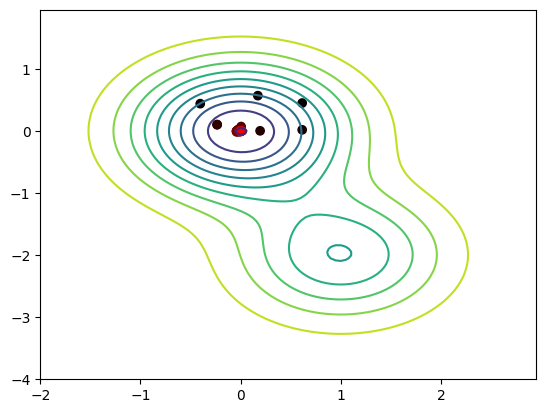

In [1136]:

ga = GeneticAlgorithm(32,2, g_x, [-20,20])
ga.run()
